
#  Install Transformers + Accelerate



In [1]:
!pip install -q transformers datasets accelerate evaluate scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.9 MB/s eta 0:00:00


# Imports

In [9]:
import pandas as pd
import numpy as np
from datasets import Dataset
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
import torch


[codecarbon INFO @ 08:15:45] Energy consumed for RAM : 0.000164 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 08:15:45] Delta energy consumed for CPU with constant : 0.000023 kWh, power : 42.5 W
[codecarbon INFO @ 08:15:45] Energy consumed for All CPU : 0.000702 kWh
[codecarbon INFO @ 08:15:45] Energy consumed for all GPUs : 0.000167 kWh. Total GPU Power : 10.263103383403491 W
[codecarbon INFO @ 08:15:45] 0.001033 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 08:15:46] Energy consumed for RAM : 0.000167 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 08:15:46] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 08:15:46] Energy consumed for All CPU : 0.000713 kWh
[codecarbon INFO @ 08:15:46] Energy consumed for all GPUs : 0.000170 kWh. Total GPU Power : 10.024401713776657 W
[codecarbon INFO @ 08:15:46] 0.001050 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 08:

# unzipping the data

In [4]:
import zipfile
import os

zip_file_path = '/content/doculizer_dataset (1).zip'

# Get the directory of the zip file
output_directory = os.path.dirname(zip_file_path)

# If the output directory is empty (i.e., zip_file_path is just a file name with no path),
# default to the current directory.
if not output_directory:
    output_directory = '.' # Current directory

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(output_directory)

print(f"Successfully unzipped '{zip_file_path}' to '{output_directory}'")

Successfully unzipped '/content/doculizer_dataset (1).zip' to '/content'


# Load the Dataset

In [5]:
import pandas as pd

# 1) Load dataset
df = pd.read_csv("/content/dataset.csv")

# 2) Keep only what we need
df = df[["abstract", "label"]]

# 3) Map string labels to ints
df["label"] = df["label"].map({"not_nlp": 0, "nlp_related": 1})

# 4) Drop any rows with missing values (just in case)
df = df.dropna(subset=["abstract", "label"])

# 5) Shuffle + reset index
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)

df.head(), df["label"].value_counts()


(                                            abstract  label
 0  Investigating the interaction of electrons in ...      0
 1  As NLP models become more integrated with the ...      1
 2  The harmonic polytope and the bipermutahedron ...      0
 3  We proposed social synergetics and the four ba...      0
 4  A contribution is presented to the application...      0,
 label
 0    1200
 1    1200
 Name: count, dtype: int64)

# split the dataset

In [6]:
from datasets import Dataset

# Convert pandas → HF Dataset
hf_dataset = Dataset.from_pandas(df)

# First: train + test
splits = hf_dataset.train_test_split(test_size=0.20, seed=42)

# Second: split train (train + val)
train_val = splits["train"].train_test_split(test_size=0.15, seed=42)

train_ds = train_val["train"]
val_ds   = train_val["test"]
test_ds  = splits["test"]

len(train_ds), len(val_ds), len(test_ds)


[codecarbon INFO @ 08:15:14] Energy consumed for RAM : 0.000080 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 08:15:14] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 08:15:14] Energy consumed for All CPU : 0.000342 kWh
[codecarbon INFO @ 08:15:14] Energy consumed for all GPUs : 0.000081 kWh. Total GPU Power : 9.905995450153599 W
[codecarbon INFO @ 08:15:14] 0.000503 kWh of electricity and 0.000000 L of water were used since the beginning.


(1632, 288, 480)

# Carbon

In [17]:
import os
!pip install codecarbon
from codecarbon import EmissionsTracker


os.makedirs("carbon_reports", exist_ok=True)

tracker = EmissionsTracker(
    output_dir="carbon_reports",
    output_file="scibert_training_emissions.csv",
    measure_power_secs=1,
)



[codecarbon WARNING @ 08:23:49] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 08:23:49] [setup] RAM Tracking...
[codecarbon INFO @ 08:23:49] [setup] CPU Tracking...
[codecarbon WARNING @ 08:23:50] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 08:23:50] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist, and are readable, at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 08:23:50] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 08:23:50] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 08:23:50] [setup] GPU Tracking...
[codecarbon INFO @ 08:23:50] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 08:23:50] The below tracking methods have been set up:
                RAM Tracking Method: RAM po

In [47]:
tracker.start()


[codecarbon WARNING @ 08:34:06] Already started tracking


# Load SciBERT Tokenizer

In [48]:
from transformers import AutoTokenizer

model_name = "allenai/scibert_scivocab_uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(
        batch["abstract"],
        padding="max_length",
        truncation=True,
        max_length=32
    )

train_tokenized = train_ds.map(tokenize, batched=True)
val_tokenized   = val_ds.map(tokenize, batched=True)
test_tokenized  = test_ds.map(tokenize, batched=True)


Map:   0%|          | 0/1632 [00:00<?, ? examples/s]

Map:   0%|          | 0/288 [00:00<?, ? examples/s]

Map:   0%|          | 0/480 [00:00<?, ? examples/s]

# Prepare SciBERT Model

In [49]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

model.to("cuda")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# Define Metrics

In [50]:
import evaluate
f1_metric = evaluate.load("f1")
acc_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    f1 = f1_metric.compute(predictions=preds, references=labels, average="binary")
    acc = acc_metric.compute(predictions=preds, references=labels)
    return {
        "accuracy": acc["accuracy"],
        "f1": f1["f1"]
    }


# Training Arguments

In [36]:
!pip install -U transformers accelerate datasets



In [51]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./scibert_classifier",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    do_eval=True,
    logging_dir="./logs",
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


# training

In [52]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    tokenizer=tokenizer,
)


/tmp/ipython-input-1928131846.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
[codecarbon WARNING @ 08:34:40] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 08:34:40] [setup] RAM Tracking...
[codecarbon INFO @ 08:34:40] [setup] CPU Tracking...
[codecarbon WARNING @ 08:34:41] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 08:34:41] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist, and are readable, at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 08:34:41] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 08:34:41] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 08:34:41] [setup] GP

In [53]:
import os
os.environ["WANDB_DISABLED"] = "true"

trainer.train()


Step,Training Loss
500,0.052600
1000,0.002900
1500,0.000100
2000,0.000000


[codecarbon INFO @ 08:35:03] Energy consumed for RAM : 0.000042 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 08:35:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:35:03] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 08:35:03] Energy consumed for all GPUs : 0.000285 kWh. Total GPU Power : 68.37195839686873 W
[codecarbon INFO @ 08:35:03] 0.000504 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 08:35:18] Energy consumed for RAM : 0.000083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 08:35:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:35:18] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 08:35:18] Energy consumed for all GPUs : 0.000560 kWh. Total GPU Power : 65.86910765988875 W
[codecarbon INFO @ 08:35:18] 0.000997 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 08:35

TrainOutput(global_step=2040, training_loss=0.013654835811272885, metrics={'train_runtime': 516.3268, 'train_samples_per_second': 31.608, 'train_steps_per_second': 3.951, 'total_flos': 268373276467200.0, 'train_loss': 0.013654835811272885, 'epoch': 10.0})

# testing

In [54]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

preds = trainer.predict(test_tokenized)
logits = preds.predictions
labels = preds.label_ids

y_pred = np.argmax(logits, axis=1)

print(classification_report(labels, y_pred, target_names=["not_nlp", "nlp_related"]))


              precision    recall  f1-score   support

     not_nlp       0.98      0.99      0.98       255
 nlp_related       0.99      0.98      0.98       225

    accuracy                           0.98       480
   macro avg       0.98      0.98      0.98       480
weighted avg       0.98      0.98      0.98       480



In [55]:
tracker.stop()

[codecarbon WARNING @ 08:43:25] Tracker already stopped !
[codecarbon INFO @ 08:43:25] Energy consumed for RAM : 0.003248 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 08:43:25] Delta energy consumed for CPU with constant : 0.007531 kWh, power : 42.5 W
[codecarbon INFO @ 08:43:25] Energy consumed for All CPU : 0.013816 kWh
[codecarbon INFO @ 08:43:25] Energy consumed for all GPUs : 0.013662 kWh. Total GPU Power : 40.77189753848397 W
[codecarbon INFO @ 08:43:25] 0.030726 kWh of electricity and 0.000000 L of water were used since the beginning.


0.010730163283254646

# Confusion Matrix

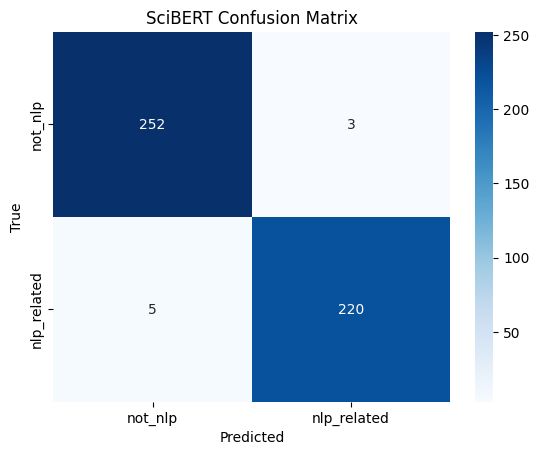

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(labels, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["not_nlp", "nlp_related"],
            yticklabels=["not_nlp", "nlp_related"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("SciBERT Confusion Matrix")
plt.show()


In [57]:
train_preds = trainer.predict(train_tokenized)
train_labels = train_preds.label_ids
train_y_pred = train_preds.predictions.argmax(axis=1)

print("TRAIN REPORT:")
print(classification_report(train_labels, train_y_pred, target_names=["not_nlp", "nlp_related"]))


TRAIN REPORT:
              precision    recall  f1-score   support

     not_nlp       1.00      1.00      1.00       795
 nlp_related       1.00      1.00      1.00       837

    accuracy                           1.00      1632
   macro avg       1.00      1.00      1.00      1632
weighted avg       1.00      1.00      1.00      1632



In [58]:
val_preds = trainer.predict(val_tokenized)
val_labels = val_preds.label_ids
val_y_pred = val_preds.predictions.argmax(axis=1)

print("VALIDATION REPORT:")
print(classification_report(val_labels, val_y_pred, target_names=["not_nlp", "nlp_related"]))


VALIDATION REPORT:
              precision    recall  f1-score   support

     not_nlp       0.99      0.99      0.99       150
 nlp_related       0.99      0.99      0.99       138

    accuracy                           0.99       288
   macro avg       0.99      0.99      0.99       288
weighted avg       0.99      0.99      0.99       288



In [59]:
test_preds = trainer.predict(test_tokenized)
test_labels = test_preds.label_ids
test_y_pred = test_preds.predictions.argmax(axis=1)

print("TEST REPORT:")
print(classification_report(test_labels, test_y_pred, target_names=["not_nlp", "nlp_related"]))


TEST REPORT:
              precision    recall  f1-score   support

     not_nlp       0.98      0.99      0.98       255
 nlp_related       0.99      0.98      0.98       225

    accuracy                           0.98       480
   macro avg       0.98      0.98      0.98       480
weighted avg       0.98      0.98      0.98       480



# **more readabale eval**

In [60]:
from sklearn.metrics import classification_report
import pandas as pd

def extract_metrics(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    return {
        "precision": report["weighted avg"]["precision"],
        "recall": report["weighted avg"]["recall"],
        "f1-score": report["weighted avg"]["f1-score"],
        "accuracy": report["accuracy"]
    }

# Train
train_metrics = extract_metrics(train_labels, train_y_pred)

# Validation
val_metrics = extract_metrics(val_labels, val_y_pred)

# Test
test_metrics = extract_metrics(test_labels, test_y_pred)

# Build comparison table
comparison_df = pd.DataFrame({
    "Metric": ["Precision", "Recall", "F1-score", "Accuracy"],
    "Train": [
        train_metrics["precision"],
        train_metrics["recall"],
        train_metrics["f1-score"],
        train_metrics["accuracy"]
    ],
    "Validation": [
        val_metrics["precision"],
        val_metrics["recall"],
        val_metrics["f1-score"],
        val_metrics["accuracy"]
    ],
    "Test": [
        test_metrics["precision"],
        test_metrics["recall"],
        test_metrics["f1-score"],
        test_metrics["accuracy"]
    ]
})

comparison_df


,Metric,Train,Validation,Test
0,Precision,1.0,0.989604,0.983358
1,Recall,1.0,0.989583,0.983333
2,F1-score,1.0,0.989582,0.983329
3,Accuracy,1.0,0.989583,0.983333


# Save the model as zip

In [39]:
trainer.save_model("./scibert_nlp_classifier")
tokenizer.save_pretrained("./scibert_nlp_classifier")


('./scibert_nlp_classifier/tokenizer_config.json',
 './scibert_nlp_classifier/special_tokens_map.json',
 './scibert_nlp_classifier/vocab.txt',
 './scibert_nlp_classifier/added_tokens.json',
 './scibert_nlp_classifier/tokenizer.json')

In [41]:
import shutil

zip_path = shutil.make_archive('scibert_nlp_classifier', 'zip', '/content/scibert_nlp_classifier')
zip_path



'/content/scibert_nlp_classifier.zip'